# Visualization Clinical Reasoning

Author: Brian Locke MD MSCI

Assistant Professor (Clinical Investigation)

Dept. of PCCM, Intermountain Health

## Overview: 

This notebook is an explainer of the methods used to combine reported (binary) likelihood ratios to multi-class reasoning

### Goal: Graphically depict reasoning using our quintile/quanlitatve Bayesian reasoning system 

- First, explain assumptions of a simple dichotomous model (do they have disease X, or not?) using diagrams Leaf Plots
- Second, explore assumptions around integrating data from multiple tests
- Third, derive a 'qualitative Bayesian' logistic-regression model that is usable for findings without substantial prior research
- Fourth, generalize findings to multi-class (several options, 1 of which is correct) reasoning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import math
from collections import namedtuple
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False


## Part 1: Theoretical Considerations

### Bayesian Reasoning

First, let's allow that probability can represent uncertainty about the the world (epistemic uncertainty) in addition to the frequency of events occuring with repeated sampling (aleatoric undertainty). Probability in Bayesian statistics represents both epistemic and aleatoric uncertainty, whereas frequentist statistics only allow aleatoric uncertainty. Bayesian statistics is much more useful for clinical reasoning, because we are mostly interested in representing uncertainty about diagnoses (there is a diagnosis, I just don't know it), which is epistemic uncertainty. 

Probabilities take a value between 0 and 1.

How these probabilities are qualitiatively described in English is imprecise and variabile, so lets start with the Intelligence Communities labels, modified to have 5 categories:
 
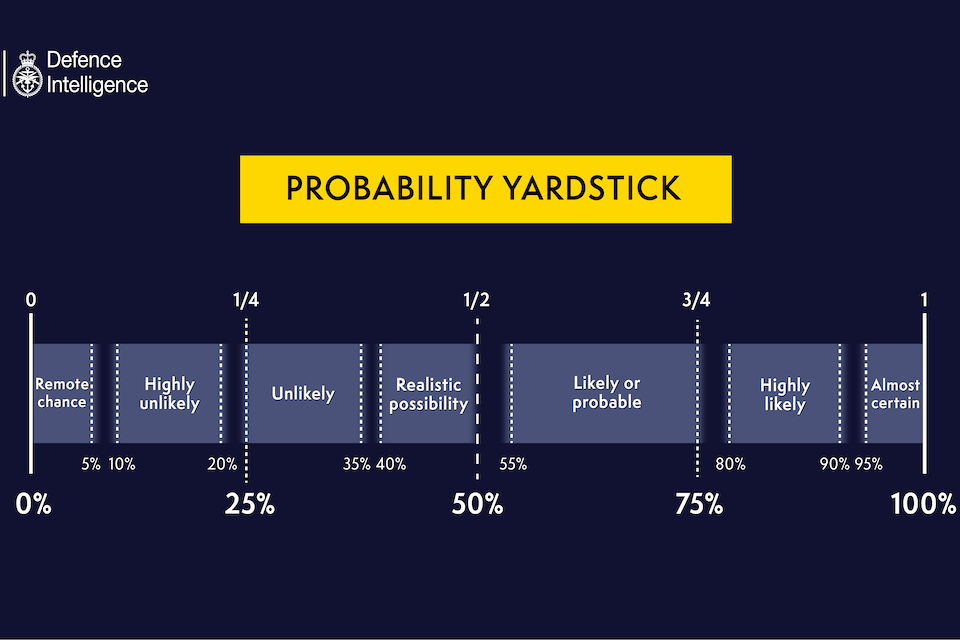

In [2]:
Range = namedtuple("Range", ["low", "high"])

old_certainty_ranges = {
    "HIGHLY_UNLIKELY": Range(0, 0.2),
    "UNLIKELY": Range(0.2, 0.4),
    "UNCERTAIN": Range(0.4, 0.6),
    "LIKELY": Range(0.6, 0.8),
    "HIGHLY_LIKELY": Range(0.8, 1)
}

The core of Bayesian reasoning is that strong evidence should should change your beliefs more than weak evidence. 

(Probability before) * (Strenth of new evidence) -> Probability After

This can be visualy represented by the following diagram from Newman and Kohn's excellent textbook, Evidence-Based Diagnosis:

TODO: find diagram

In this diagram, probability is represented by the number line, and the amount that the finding should change our belief is represented by the arrow. 

### Odds

Bayes theorem uses odds, not probability, for reasons we shall return to. 

Odds: 
$$
\text{Odds of an event} = \frac{\text{Probability of the event}}{\text{Probability of the event not happening}}
$$

This is sometimes written as: 
$$
\text{Odds} = \frac{\text{P}}{\text{1 - P}}
$$

Probabilities take values between 0 and 1; Odds take values between 0 and infinity. 

Likelihood ratios represent how much you should update your assessment of the odds of something with new information. The likelihood ratio formulation of Bayes theorem uses odds as inputs and outputs. 

Relationship between pre-test and post-test odds:
$$
\text{Post-test Odds} = \text{Pre-test Odds} \times \text{Likelihood Ratio}
$$

In Python, the post-test probability can be calculated by: 

1. First, converting the pre-test probability to odds. 
2. Second, multiplying the pre-test odds by the likelihood ratio to calculate the post-test odds
3. Third, converting the post-test odds to probability 

In [3]:
# Helper functions
def probability_to_odds(probability: float) -> float:
    """Convert probability to odds."""
    if np.any(probability < 0) or np.any(probability > 1):
        print(f"Invalid probability encountered: {probability}")
        raise ValueError("Probability must be between 0 and 1 (inclusive).")
    return probability / (1 - probability)

def odds_to_probability(odds: float) -> float:
    """Convert odds to probability."""
    if np.any(odds < 0):        
        print(f"Invalid odds encountered: {odds}")
        raise ValueError("Odds must be non-negative.")
    return odds / (1 + odds)

def bayesian_update_odds(pre_test_odds: float, likelihood_ratio: float) -> float:
    """
    Calculate post-test odds.

    Args:
        pre_test_odds (float): Pre-test odds
        likelihood_ratio (float): Likelihood ratio (positive value).

    Returns:
        float: Post-test odds
    """
    if likelihood_ratio <= 0:
        print(f"Invalid LR encountered: {likelihood_ratio}")
        raise ValueError("Likelihood ratio must be non-negtative.")
    return pre_test_odds * likelihood_ratio

def bayesian_update_prob(pre_test_prob: float, likelihood_ratio: float) -> float:
    """
    Calculate post-test probability.

    Args:
        pre_test_prob (float): Pre-test probability (0 <= pre_test_prob <= 1).
        likelihood_ratio (float): Likelihood ratio (positive value).

    Returns:
        float: Post-test probability.
    """
    if pre_test_prob < 0 or pre_test_prob > 1: 
        print(f"Invalid pre-test probability encountered: {pre_test_prob}")
        raise ValueError("Pre-test probability must be between 0 and 1 (inclusive).")
    if likelihood_ratio <= 0:
        print(f"Invalid LR encountered: {likelihood_ratio}")
        raise ValueError("Likelihood ratio must be non-negtative.")

    pre_test_odds = probability_to_odds(pre_test_prob)
    post_test_odds = bayesian_update_odds(pre_test_odds, likelihood_ratio)
    return odds_to_probability(post_test_odds)

In the context of disease diagnostics, likelihood ratios can be generated by: 

$$
\text{Likelihood ratio(finding)} = \frac{P(\text{finding} \mid \text{disease})}{P(\text{finding} \mid \text{no disease})}
$$

where the parenthesis mean "of" and the bar "|" means "when there is". A finding could refer to a test result, an exam finding, a historical feature from the HPI, or any other piece of evidence.

This value of the likelihood ratio can be calculated if you know four frequencies: 

- A: Number of people with the disease and the finding
- B: Number of people with the disease and not the finding
- C: Number of people without the disease and with the finding
- D: Number of people with neither the disease nor the finding

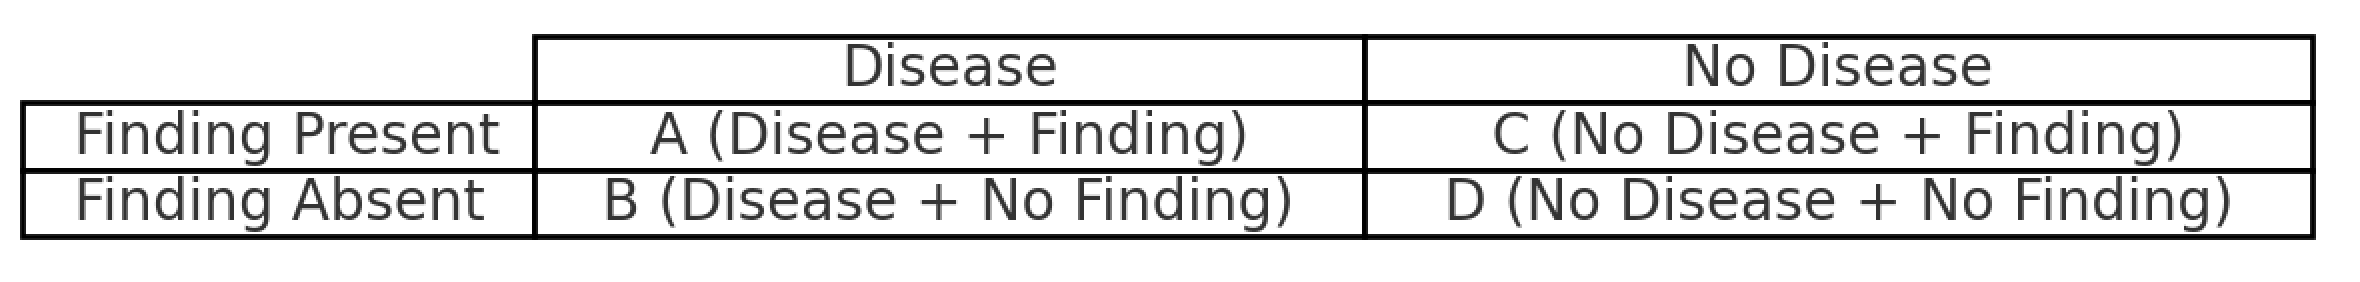

If you know those things, you can calculate the likelihood ratio for a positive test as:

$$
LR^+ = \frac{\frac{A}{A+B}}{\frac{C}{C+D}}
$$
and 
$$
LR^- = \frac{\frac{B}{A+B}}{\frac{D}{C+D}}
$$

The exact formula isn't as important as recognizing that both the frequency of cases (people with disease: A and B) and non-cases (C and D) are required for the LR's to be accurate. 

This means, the *spectrum of cases and non-cases* where the LR's were derived from must be similar to the case where you apply the LRs. 

***ASSUMPTION 1:*** The spectrum of CASES and NONCASES where the estimates were derived are similar to way they will be applied.

One brief bit of math to get out of the way. Often times it makes more sense to work in logarthms of the odds for reasons that will become clear shortly. 

In [4]:
# Helper functions
def prob_to_logodds(prob):
    if prob <= 0 or prob >= 1:
        raise ValueError("Probability must be strictly between 0 and 1.")
    return np.log(prob / (1 - prob))

def logodds_to_prob(logodds):
    return np.exp(logodds) / (1 + np.exp(logodds))

#### Question: What is the implication of using odds instead of probabilities for Bayes rule? 

Answer: To go from P = 0.8 (= odds 4) to 0.9 (= odds 9) takes stronger evidence (requires LR 2.25) than from 0.7 (= odds 2.33) to 0.8 (= odds 4, requires LR 1.71)

Similarly, going from 0.9 (= odds 9) to 1.0 (= odds infinity) even stronger evidence still - utterly conclusive! 

We can show this graphically, using several figures - generated by this program: 

In [5]:
# Program to update demonstrate probability vs odds and log-odds
def bayesian_update_plot(
    prior,
    lrs,
    scale="linear",
    tick_probs=None,
    min_prob=0.01,
    max_prob=0.99,
    figsize=(8, 4)
):
    """
    Generate a plot showing how multiple LRs update a single
    prior probability. Supports linear, probability on a log(odds) scale, and odds scales.
    All inputs are probabilities

    Parameters
    ----------
    prior : float
        Pre-test probability (0 < prior < 1).
    lrs : list of float
        One or more likelihood ratios for individual tests.
    scale : str, optional
        "linear", "log", or "odds". Default is "linear".
    tick_probs : list of float, optional
        Probability values at which to place ticks on the x-axis.
        E.g., [0.01, 0.1, 0.5, 0.9]. The function converts them as needed
        for each scale. If None, defaults are provided per scale.
    min_prob, max_prob : float, optional
        The overall probability range to display on the x-axis (0 to 1).
        If scale="odds" or "log", these will be internally converted to
        odds or log-odds for plotting.
    figsize : tuple of float, optional
        Size of the Matplotlib figure.

    Returns
    -------
    None
        Plots the figure directly.
    """
    # --- Pre-calculate posterior odds ---
    prior_odds = probability_to_odds(prior)
    posteriors_odds = [prior_odds * lr for lr in lrs]
    combined_lr = np.prod(lrs)
    combined_odds = prior_odds * combined_lr

    posteriors_prob = [bayesian_update_prob(prior, lr) for lr in lrs]
    combined_prob = bayesian_update_prob(prior, combined_lr)

    # --- Determine x-axis data, ticks, labels ---
    if scale == "linear":
        x_array = np.linspace(min_prob, max_prob, 200)
        if tick_probs is None:
            tick_probs = np.linspace(min_prob, max_prob, 5)
        x_ticks = tick_probs
        x_tick_labels = [f"{p:.2f}" for p in tick_probs]
        x_label = "Probability (0 to 1, linear scale)"
        x_prior = prior
        x_posteriors = posteriors_prob
        x_combined = combined_prob

    elif scale == "log":
        start_logodds = prob_to_logodds(min_prob)
        end_logodds = prob_to_logodds(max_prob)
        x_array = np.linspace(start_logodds, end_logodds, 200)
        if tick_probs is None:
            tick_probs = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95]
        x_ticks = [prob_to_logodds(tp) for tp in tick_probs]
        x_tick_labels = [f"{tp:.2f}" for tp in tick_probs]
        x_label = "Probability (log-odds scale)"
        x_prior = prob_to_logodds(prior)
        x_posteriors = [prob_to_logodds(p) for p in posteriors_prob]
        x_combined = prob_to_logodds(combined_prob)

    elif scale == "odds":  #same as log, but with odds labels rather than probs
        odds_min = probability_to_odds(min_prob)
        odds_max = probability_to_odds(max_prob)
        x_array = np.logspace(np.log10(odds_min), np.log10(odds_max), 200)
        if tick_probs is None:
            tick_probs = [0.01, 0.1, 0.5, 0.9, 0.99]
        x_ticks_odds = [probability_to_odds(tp) for tp in tick_probs]
        x_ticks = x_ticks_odds
        x_tick_labels = [f"{o:.3g}" for o in x_ticks_odds]
        x_label = "Odds of Disease (log10 axis)"
        x_prior = prior_odds
        x_posteriors = posteriors_odds
        x_combined = combined_odds

    else:
        raise ValueError("Invalid scale. Choose 'linear', 'log', or 'odds'.")

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_array, np.zeros_like(x_array), 'k-')
    if scale == "odds":
        ax.set_xscale("log")
    ax.set_xlim(x_array[0], x_array[-1])
    ax.set_ylim(-0.15, 0.18)  # Enough vertical space for multiple arrows
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel(x_label)
    ax.set_yticks([])  # Hide y-axis ticks, since we only plot horizontal arrows
    color_list = [f"C{i}" for i in range(len(lrs))]
    for i, (lr, x_post) in enumerate(zip(lrs, x_posteriors)):
        y_arrow = 0.15 - i * 0.05
        color = color_list[i]
        ax.axvline(x=x_prior, color=color, linestyle="--", alpha=0.3)
        ax.axvline(x=x_post, color=color, linestyle="--", alpha=0.3)
        ax.annotate(
            "",
            xy=(x_post, y_arrow),
            xytext=(x_prior, y_arrow),
            arrowprops=dict(arrowstyle="<|-|>", color=color, lw=2),
        )
        ax.text(
            (x_prior + x_post) / 2,
            y_arrow - 0.03,
            f"LR={lr}",
            ha="center",
            color=color
        )
    if len(lrs) > 1:
        y_arrow_combined = 0.15 - len(lrs) * 0.05
        ax.axvline(x=x_prior, color="red", linestyle="--", alpha=0.3)
        ax.axvline(x=x_combined, color="red", linestyle="--", alpha=0.3)
        ax.annotate(
            "",
            xy=(x_combined, y_arrow_combined),
            xytext=(x_prior, y_arrow_combined),
            arrowprops=dict(arrowstyle="<|-|>", color="red", lw=2),
        )
        ax.text(
            (x_prior + x_combined) / 2,
            y_arrow_combined - 0.03,
            f"Combined LR={combined_lr:.1f}",
            ha="center",
            color="red"
        )

    ax.set_title(
        f"Bayesian Update with {scale.capitalize()} Scale\n"
        f"Prior: {prior:.3g}; LRs: {lrs}"
    )
    plt.tight_layout()
    plt.show()

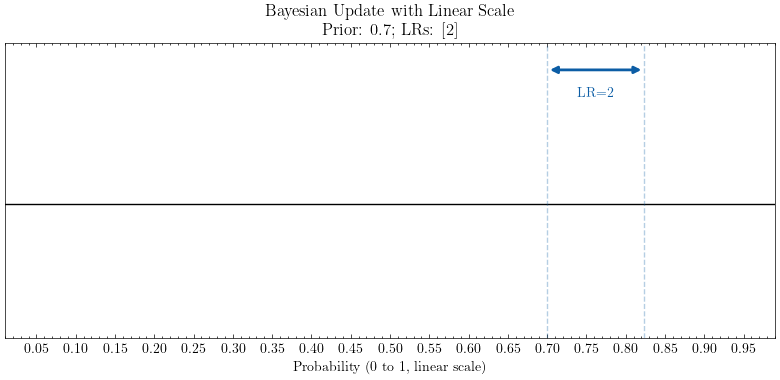

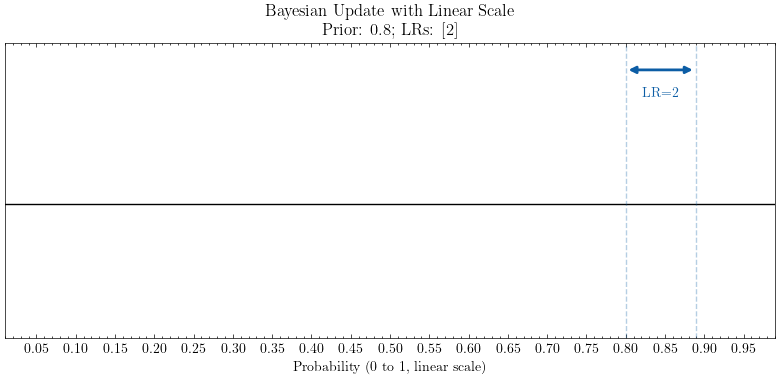

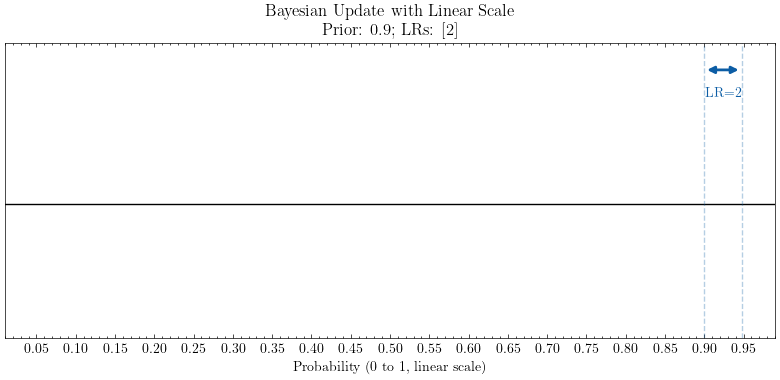

In [6]:
# Same finding, different pre-test probability
bayesian_update_plot(prior=0.7, lrs=[2], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")
bayesian_update_plot(prior=0.8, lrs=[2], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")
bayesian_update_plot(prior=0.9, lrs=[2], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")

As you can see - the same finding moves the needle less in probability space the closer you get to one. 

However, transforming this to an odds formulation makes it so that the same finding moves things the same amount. 

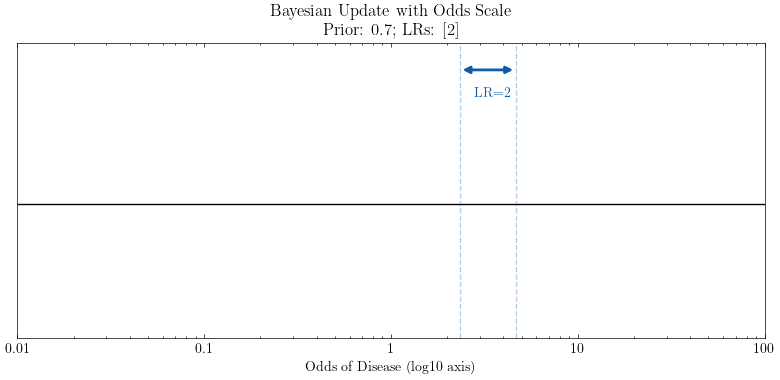

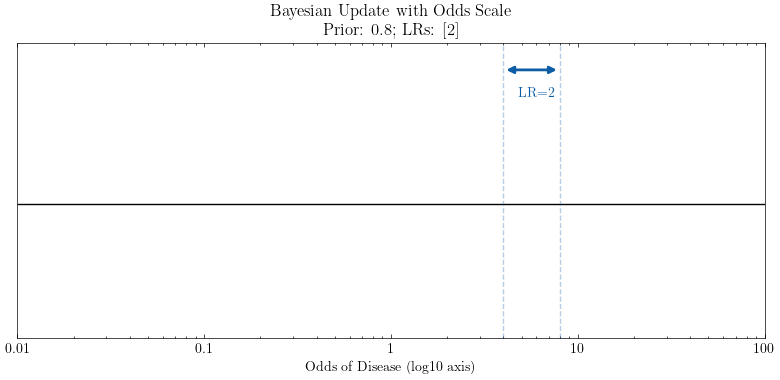

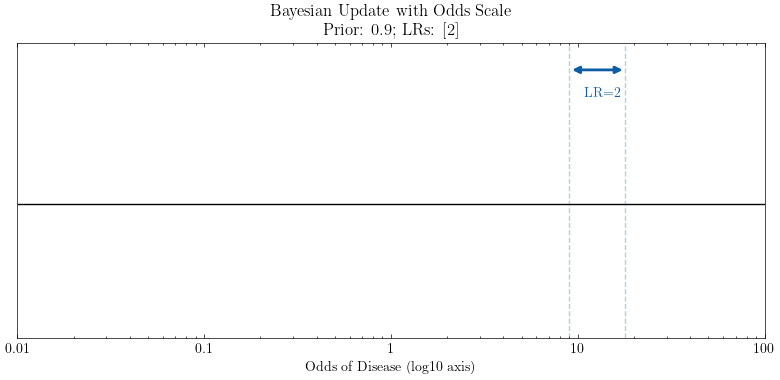

In [7]:
# Same finding, different pre-test probability
bayesian_update_plot(prior=0.7, lrs=[2], tick_probs = odds_to_probability(np.logspace(-2, 2, 5)), scale="odds")
bayesian_update_plot(prior=0.8, lrs=[2], tick_probs = odds_to_probability(np.logspace(-2, 2, 5)), scale="odds")
bayesian_update_plot(prior=0.9, lrs=[2], tick_probs = odds_to_probability(np.logspace(-2, 2, 5)), scale="odds")

As you can see, on this scale, the amount that the test "moves the needle" (ie. how much you should update) is consistent.

### Log-odds

Likelihood ratios summarize the strength of evidence, with stronger evidence being further from 1. However, the scale is weird: a finding with a LR 0.5 is equivalently strong evidence as an LR of 2. The only difference is that the direction is switched. 

This is because likelihood ratios are *ratios* , and thus are best represented on a multiplicative scale rather than an additive (linear) one. Meaning *halving* the odds and *doubling* the odds represent similarly informative events. 

Logarithms enable us to convert this multiplicative scale to a linear one (and exponentiating allows you to go back). If we take the logarithm of both sides of Bayes formula we get: 

$$
\log(\text{Post-test Odds}) = \log(\text{LR}) + \log(\text{Pre-test Odds})
$$

Recall, that Log (A * B) = Log(A) + Log(B). Log(odds of A) is often shortened/said as "Log-odds(A)" and the Log(LR) is sometimes called the "Weight of Evidence". The log scale is often referred to as the 'logit' scale. 

Logarithms are unintuitive to everyone, but this expression has several nice features: 
- A finding with a Log(LR) -1 (= LR 0.5) and a finding with a log(LR) = 1 (= LR = 2) are equally informative, and equally far from 0 (= not at all informative)
- If the log-odds of an event happening is 0, odds = 1 and p = 0.5 (meaning, it is equally likely to happen as not). Evidence will move the log-odds away from 0 linearly with how strong the evidence is (e.g. if the log-odds is 2, then twice as much as evidence in favor has been mustered as if log-odds is 1)

In [8]:
def bayesian_update_log_odds(pre_test_log_odds, weight_of_evidence):
    """Calculate post-test log-odds from pre-test log-odds and the log(LR) aka weight of evidence."""
    return pre_test_log_odds + weight_of_evidence



### Leaf Plot

We can generalize this relationship across pre-test probabilities and hypothetical findings of several strengths using a leaf plot:
- the x-axis represents the pre-test probability 
- the y-axis represents the post-test probabilities 
- each line represents a finding of a given strength. 

If you trace vertically from the pre-test probability to the line representing the strength of evidence, then you trace horizontally to the post-test probability. 

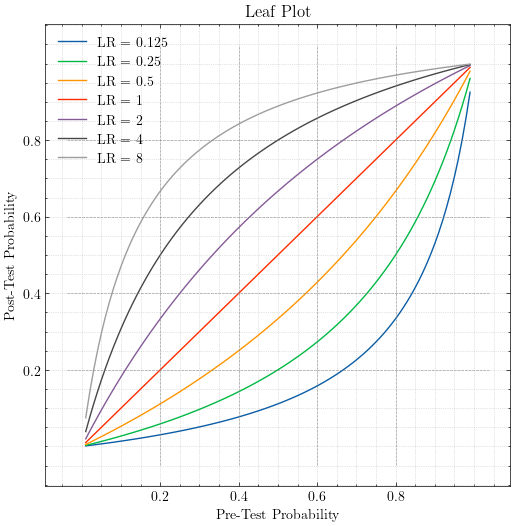

In [9]:
def leaf_plot(likelihood_ratios=None, grid_positions=None, figsize=(6, 6)):
    """Plots a Leaf Plot.

    Args:
        likelihood_ratios (list, optional): A list of likelihood ratios to plot.
        grid_positions (list, optional): A list of grid positions for x and y axes.
    """

    pre_test_probs = np.arange(0.01, 1, 0.01)
    
    # Default likelihood_ratios if none are provided
    if likelihood_ratios is None:
        likelihood_ratios = [0.125, 0.25, 0.5, 1, 2, 4, 8]

    fig, ax = plt.subplots(figsize=figsize)
    for lr in likelihood_ratios:
        post_test_probs = [bayesian_update_prob(p, lr) for p in pre_test_probs]
        ax.plot(pre_test_probs, post_test_probs, label=f"LR = {lr}")

    # Set grid positions at 0.2, 0.4, 0.6, and 0.8 corresponding to qualitative categories

    # Default grid_positions if none are provided
    if grid_positions is None:
        grid_positions = [
            old_certainty_ranges["HIGHLY_UNLIKELY"][1], 
            old_certainty_ranges["UNLIKELY"][1], 
            old_certainty_ranges["UNCERTAIN"][1], 
            old_certainty_ranges["LIKELY"][1]
        ]
    ax.set_xticks(grid_positions)
    ax.set_yticks(grid_positions)

    # Add faint dotted grid lines
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    ax.vlines(grid_positions, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.hlines(grid_positions, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.set_xlabel("Pre-Test Probability")
    ax.set_ylabel("Post-Test Probability")
    ax.set_title("Leaf Plot")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    leaf_plot()

If you make the same plot with all probabilities transformed to odds, the shape changes. 

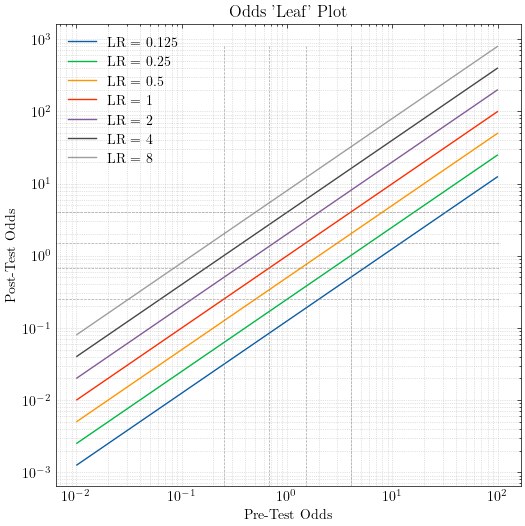

In [10]:
def odds_leaf_plot(likelihood_ratios=None, grid_positions=None, figsize=(6, 6)):
    """Plots an Odds Leaf Plot.

    Args:
        likelihood_ratios (list, optional): A list of likelihood ratios to plot.
        grid_positions (list, optional): A list of grid positions for x and y axes in odds.
    """

    # Generate pre-test probabilities and convert to odds
    pre_test_probs = np.arange(0.01, 1, 0.01)
    pre_test_odds = probability_to_odds(pre_test_probs)
    
    # Default likelihood_ratios if none are provided
    if likelihood_ratios is None:
        likelihood_ratios = [0.125, 0.25, 0.5, 1, 2, 4, 8]

    fig, ax = plt.subplots(figsize=figsize)
    for lr in likelihood_ratios:
        post_test_odds = [bayesian_update_odds(o, lr) for o in pre_test_odds]
        ax.plot(pre_test_odds, post_test_odds, label=f"LR = {lr}")

    # Default grid_positions if none are provided (set using predefined odds ranges)
    if grid_positions is None:
        grid_positions = [probability_to_odds(p) for p in [0.2, 0.4, 0.6, 0.8]]

    # Add faint dotted grid lines with logarithmic axes
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    ax.tick_params(which='both', bottom=False, left=False)  # Disable minor ticks
    ax.set_xticks(grid_positions)
    ax.set_yticks(grid_positions)
    
    ax.vlines(grid_positions, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.hlines(grid_positions, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.set_xscale('log')  # Set x-axis to logarithmic scale
    ax.set_yscale('log')  # Set y-axis to logarithmic scale

    ax.set_xlabel("Pre-Test Odds")
    ax.set_ylabel("Post-Test Odds")
    ax.set_title("Odds 'Leaf' Plot")
    ax.legend()
    plt.show()

odds_leaf_plot()

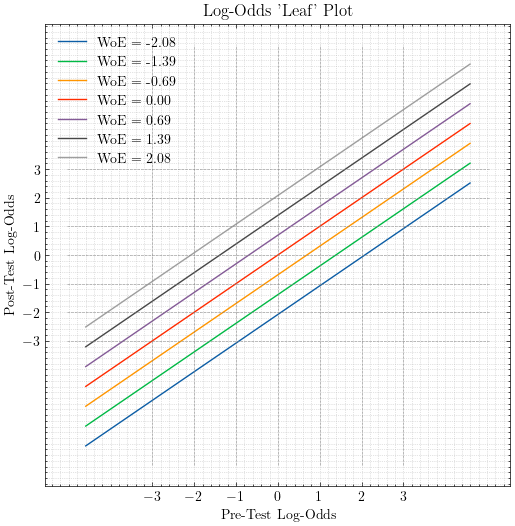

In [11]:
def log_odds_leaf_plot(weights_of_evidence=None, grid_positions=None, figsize=(6, 6)):
    """Plots a Log-Odds Leaf Plot.

    Args:
        weights_of_evidence (list, optional): A list of weights of evidence (log(likelihood ratios)) to plot.
        grid_positions (list, optional): A list of grid positions for x and y axes in log-odds.
    """

    # Generate pre-test probabilities and convert to log-odds
    pre_test_probs = np.arange(0.01, 1, 0.01)
    pre_test_odds = probability_to_odds(pre_test_probs)
    pre_test_log_odds = np.log(pre_test_odds)
    
    # Default weights_of_evidence if none are provided
    if weights_of_evidence is None:
        likelihood_ratios = [0.125, 0.25, 0.5, 1, 2, 4, 8]
        weights_of_evidence = np.log(likelihood_ratios)

    fig, ax = plt.subplots(figsize=figsize)
    for wo in weights_of_evidence:
        post_test_log_odds = [bayesian_update_log_odds(lo, wo) for lo in pre_test_log_odds]
        ax.plot(pre_test_log_odds, post_test_log_odds, label=f"WoE = {wo:.2f}")

    # Default grid_positions if none are provided
    if grid_positions is None:
        grid_positions = np.linspace(-3, 3, 7)  # Example grid spanning -3 to 3 log-odds

    ax.set_xticks(grid_positions)
    ax.set_yticks(grid_positions)
    ax.vlines(grid_positions, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.hlines(grid_positions, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add faint dotted grid lines
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    ax.set_xlabel("Pre-Test Log-Odds")
    ax.set_ylabel("Post-Test Log-Odds")
    ax.set_title("Log-Odds 'Leaf' Plot")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    log_odds_leaf_plot()

### Summary: 

In many ways, the log odds scale is the natural "scale" for thinking about evidence. This allows the cumulative strength of evidence to be represented in a linear fashion. 

## Part 2: Multiple tests

One can imagine that when multiple pieces of evidence are available (e.g. multiple tests, multiple exam findings, etc.), you can apply Bayes rule on the first test, followed by the second. 

$$
\text{Post-test-1 Odds} = \text{Pre-test Odds} \times \text{Likelihood Ratio-1}
$$

then 

$$
\text{Post-test-2 Odds} = \text{Post-test-1 Odds} \times \text{Likelihood Ratio-2}
$$

or, equivalently

$$
\text{Post-test-2 Odds} = \text{Pre-test Odds} \times \text{Likelihood Ratio-1} \times \text{Likelihood Ratio-2}
$$

For example, if you started out considering a diagnosis that was uncertain (probability = 0.5), and then got two tests: 

- Test 1: LR+ 2
- Test 2: LR+ 1.5

Then, 

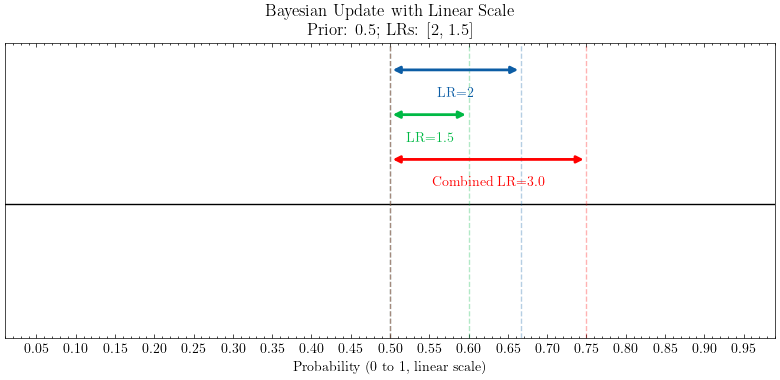

In [12]:
bayesian_update_plot(prior=0.5, lrs=[2, 1.5], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")

Or, in odds space (transformed logarithmically)

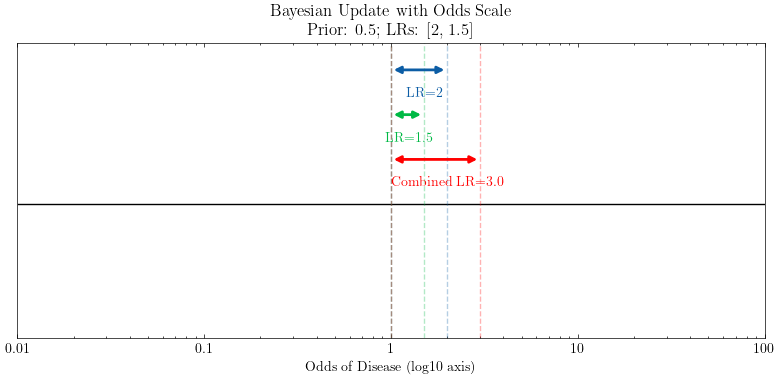

In [13]:
bayesian_update_plot(prior=0.5, lrs=[2, 1.5], tick_probs = odds_to_probability(np.logspace(-2, 2, 5)), scale="odds")

This can work for increasingly large sets of tests - even when some make the disease more likely or less likely. 

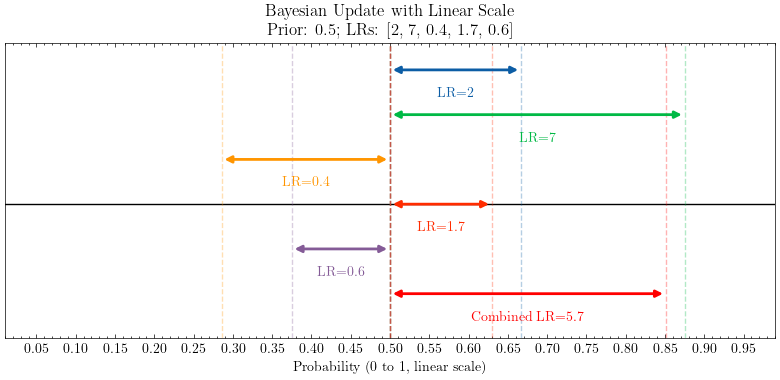

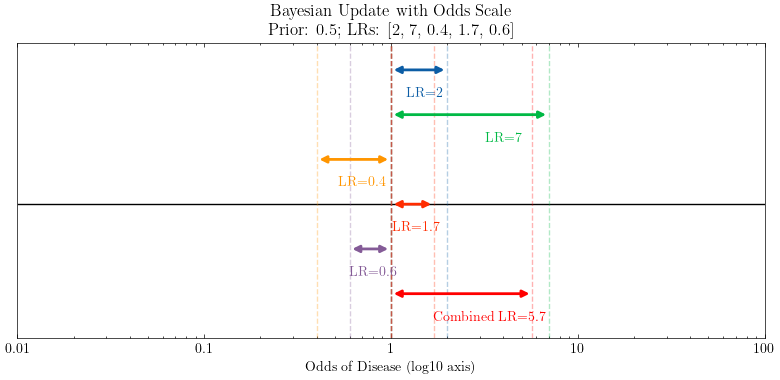

In [14]:
bayesian_update_plot(prior=0.5, lrs=[2, 7, 0.4, 1.7, 0.6], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")
bayesian_update_plot(prior=0.5, lrs=[2, 7, 0.4, 1.7, 0.6], tick_probs = odds_to_probability(np.logspace(-2, 2, 5)), scale="odds")

### Independence of tests

However, both tests must provide independent evidence for this to accurately describe reality. For example, if you ask a question about "do you have known coronary artery disease?" and "do you have cerebrovascular disease?", those aren't two independent pieces of information because they both partially represent one predictor: do you have sequalae of atherosclerosis. 

What this means is that the first question does not add the same amount of information if the first question has already been answered. 


Example from Newman and Kohn about tests for Downs Syndrome

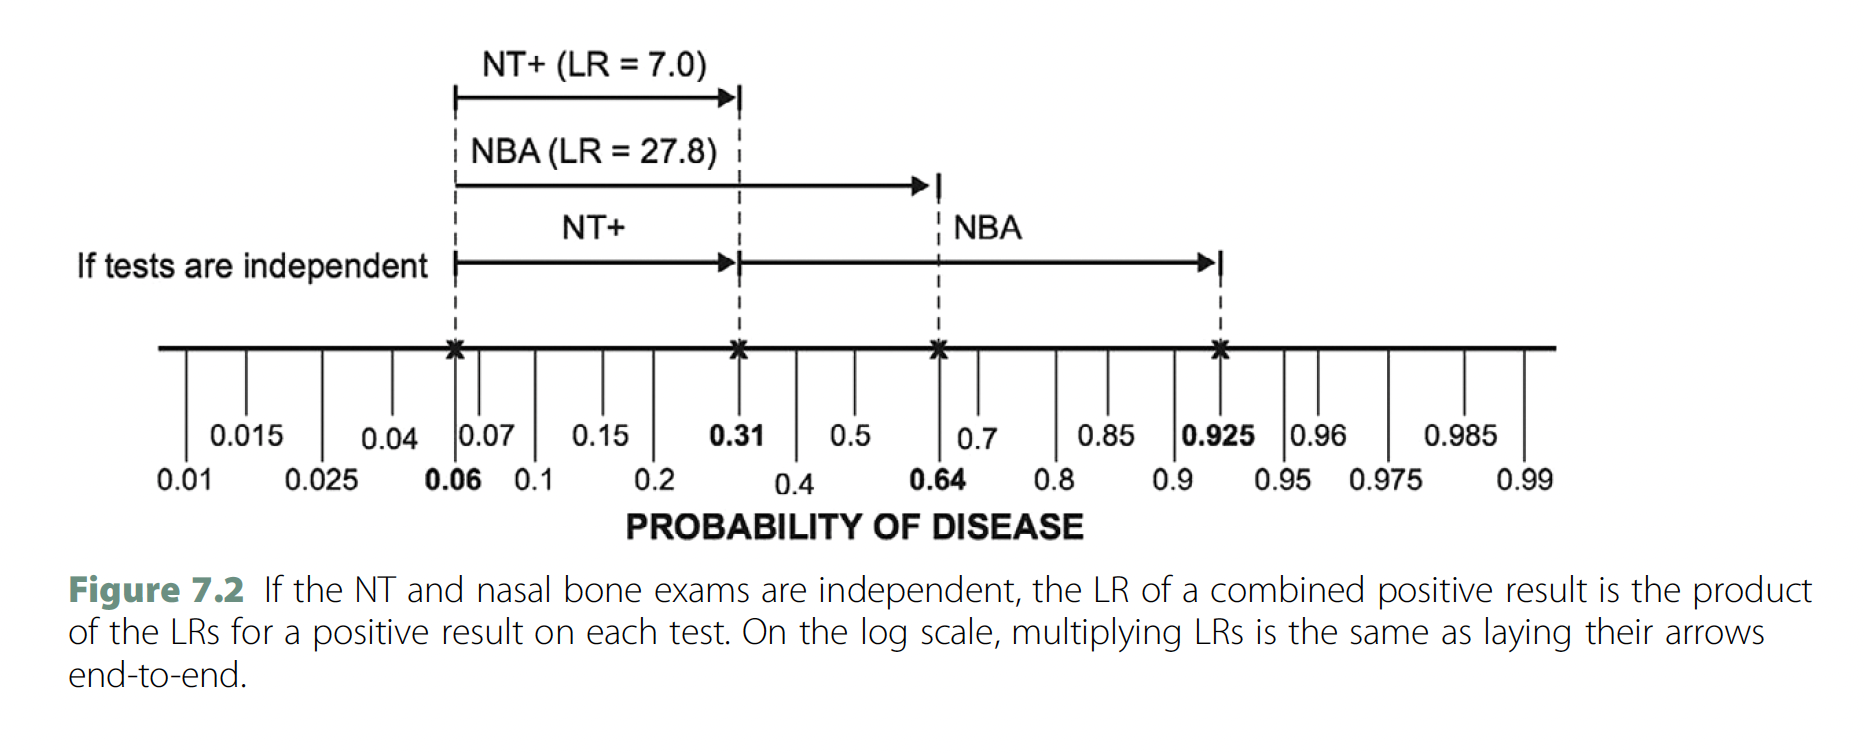

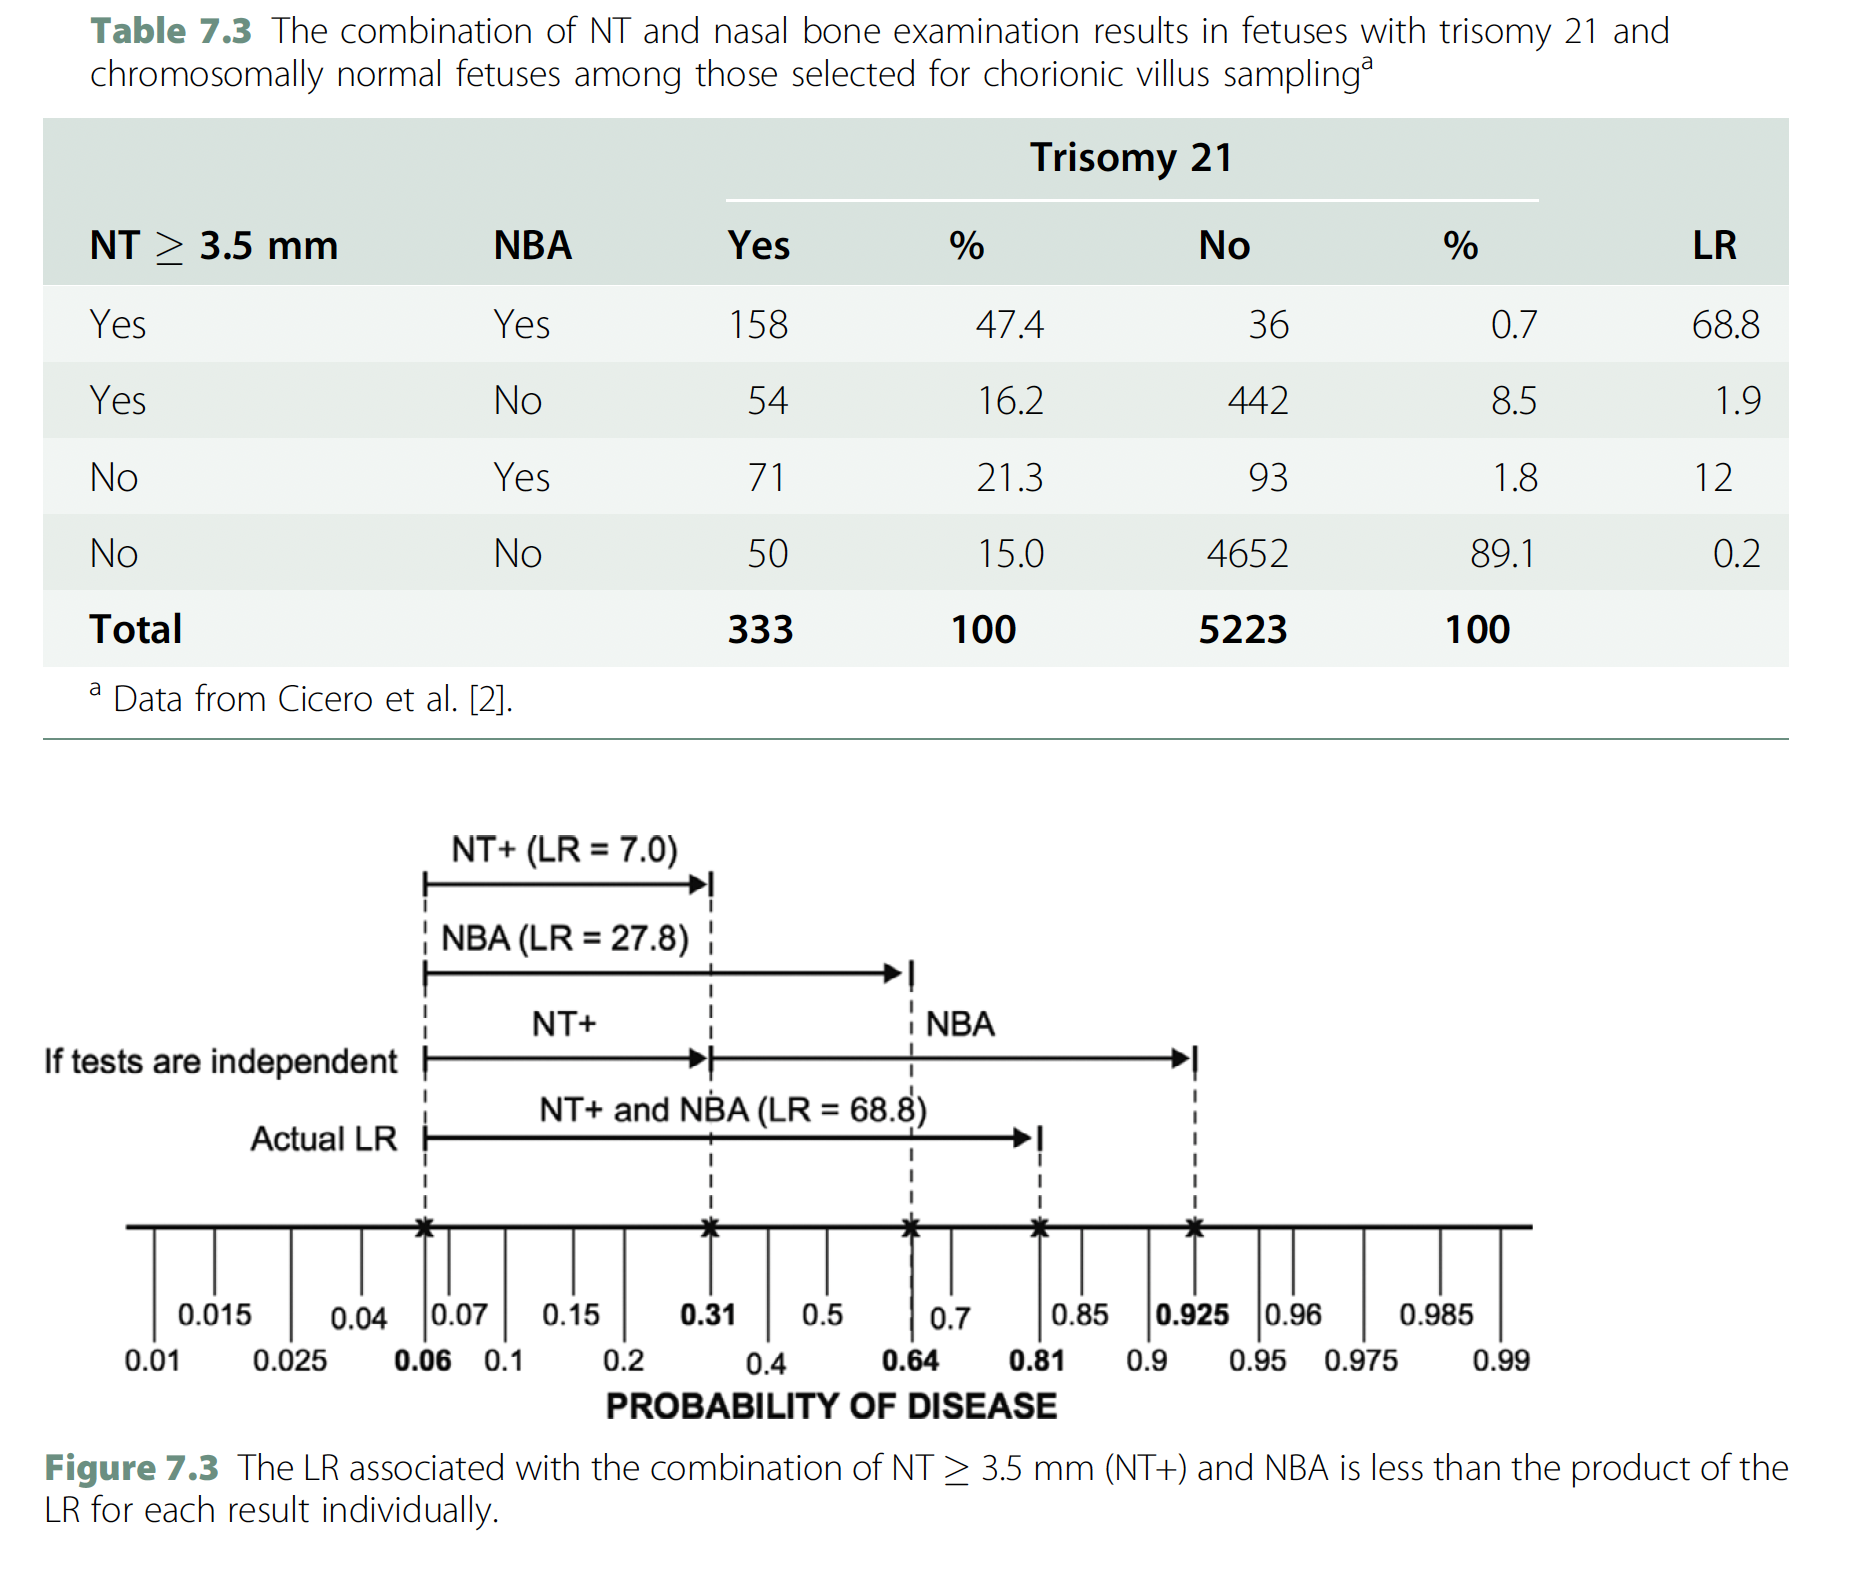

Assuming the evidence is independent is often called "Naive Bayes" in machine learning, which often works suprisingly well despite not being true. 

In order to avoid making this 'independence' assumption, you need to have the raw data of how often each combination of findings occurs in patients with and without the disease - which needs to be an implausibly large dataset as the number of factors increases. This is one of many crux issues in machine learning. 


***ASSUMPTION 2***: Independence of Tests

## Part 3 Qualitative Bayes

In the real world, no-one bothers to estimate precise pre-test probabilities (or odds; or log-odds) nor calculate precise post-test probabilities. Nor should they: 

- precise estimates of LR's that correctly describe the spectrum of disease (***ASSUMPTION 1***) are usually not available.  
- we don't know how most findings interact with other findings (***ASSUMPTION 2***)
- we are often not reasoning about just cases and non-cases, but rather multiple diseases which may explain the patient's chief complaint (discussed below)
- we usuall don't *need* to know precise estimates - just close enough to make the right decision.

Yet, the framework is *probably* still useful if it gets you in the right ballpark. 

So, maybe we can use a framework that uses only rough estimates will get us close enough?

This idea - though with different thresholds - has been published previously: https://ebm.bmj.com/content/16/6/163 

### Should we modify our qualitative categories? 

Above, we said we'd call 0-20% highly unlikely, 20-40% unlikely, 40-60% uncertain, 60-80% certain, and 80-100% highly certain. However, this is on the linear scale. 

As explained above, the "log-odds" scale is much simpler for representing information (we will return to this). In log odds, those threshold probabilities convert to: 

In [15]:
probabilities = [0.2, 0.4, 0.6, 0.8]
odds = [probability_to_odds(prob) for prob in probabilities] # Convert each probability to log-odds
print("Odds:", [f"{od:.3f}" for od in odds])

log_odds = [prob_to_logodds(prob) for prob in probabilities] # Convert each probability to log-odds
print("Log-Odds:", [f"{lo:.3f}" for lo in log_odds])

Odds: ['0.250', '0.667', '1.500', '4.000']
Log-Odds: ['-1.386', '-0.405', '0.405', '1.386']


As we can see, these are not evenly spaced categories, which will be a problem if we want LR's to have a similar effect regardless what category one start with. 

However, we CAN choose categories so that they are evenly spaced on the log-odds scale. We then define labels that correspond to the amount of evidence needed to jump between categories:

In [16]:
log_odds = [-1.5, -0.5, 0.5, 1.5] # arbitrary choice based on roughly how strong most evidence is. 
probabilities = [logodds_to_prob(lo) for lo in log_odds]
print("Probabilities: ",  [f"{prob:.3f}" for prob in probabilities])

Probabilities:  ['0.182', '0.378', '0.622', '0.818']


Meaning, our new categories are: 

- 0% - 18.2%: Highly Unlikely
- 18.2% to 37.8% Unlikely
- 37.8% to 62.2% Uncertain
- 62.2% to 81.8% Likely
- 81.8% to 100% Highly Likely. 

And, if we were going to generate representative point estimates for each category, they might correspond to: 

In [17]:
log_odds = [-2, -1, 0, 1, 2] # thresholds between categories on the log-odds scale. 
probabilities = [logodds_to_prob(lo) for lo in log_odds]
print("Probabilities: ",  [f"{prob:.3f}" for prob in probabilities])

Probabilities:  ['0.119', '0.269', '0.500', '0.731', '0.881']


Mathematically, these are the geometric means (aka the mean on the logarithmic scale) of the ranges

- 11.9%: Highly Unlikely
- 26.9% Unlikely
- 50% Uncertain
- 73.1% Likely
- 88% Highly Likely. 

A natural next question would be, how strong does the evidence need to be to move up or down 1 qualitative category? 

In the log-odds scale, it is easy to see that 'weight of evidence' (WoE) = 1 would on average move you up 1 qualitative category and WoE = -1 would move you down a category. 

Exponentiating these WoE's to return them to likelihood ratios yields: 

$$
\exp(1) = e \approx 2.718
$$
and
$$
\exp(-1) = \frac{1}{e} \approx 0.368
$$

If we say a "strong feature" is one that changes the odds of a disease being present by 1 qualitative category, the LR+ is roughly 2.718 and the LR- is 0.368. 


We can confirm this is true in probability-space using a leaf diagram. If you start (x-axis) anywhere in each bin and get a positive result, you move up a category on the y-axis (and vice-versa for a negative result) 

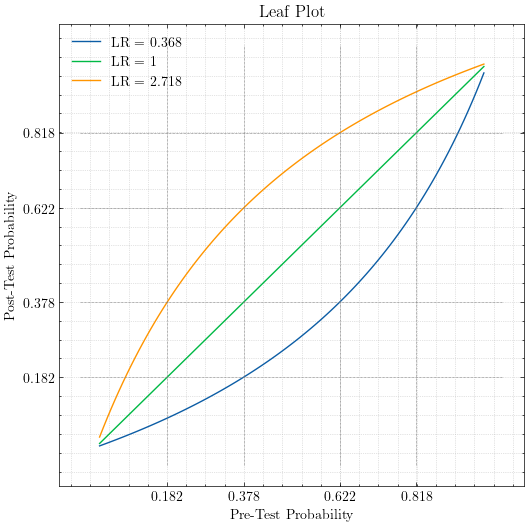

In [18]:
# new certainty estimates: 
certainty_ranges = {
    "HIGHLY_UNLIKELY": Range(0, 0.182),
    "UNLIKELY": Range(0.182, 0.368),
    "UNCERTAIN": Range(0.368, 0.622),
    "LIKELY": Range(0.622, 0.818),
    "HIGHLY_LIKELY": Range(0.818, 1)
}

def get_certainty_label(probability):
# Function to find the corresponding key
    for label, range_ in certainty_ranges.items():
        if range_.low <= probability < range_.high:
            return label
    return "Out of range"

# representative estimates for calcs
certainty_estimates = {
    "HIGHLY_UNLIKELY": 0.119,
    "UNLIKELY": 0.269,
    "UNCERTAIN": 0.5,
    "LIKELY": 0.731,
    "HIGHLY_LIKELY": 0.881
}

custom_gps = [0.182, 0.378, 0.622, 0.818] # corresponds to log-odds:  -1.5, -0.5, 0.5, 1.5 -> 
custom_lrs=[0.368, 1, 2.718] # corresponds to evidence needed to move 1 cat LR of e or 1/e moves a category
leaf_plot(likelihood_ratios= custom_lrs, grid_positions=custom_gps)

As you can see... if you start in any pre-test probability bucket (e.g. between 0.18 and 0.378), a strong positive finding (green line) mooves you into the next higher post-test probability bucket (between 0.378 and 0.622).

Or, more easily seen in logarthmic space

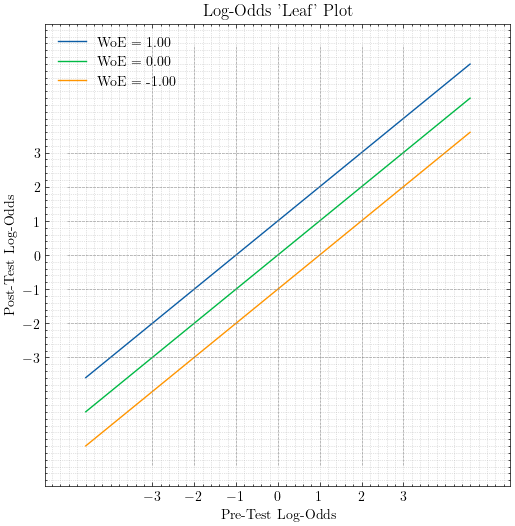

In [19]:
likelihood_ratios = [math.e, 1, 1/math.e]
weights_of_evidence = np.log(likelihood_ratios)

log_odds_leaf_plot(weights_of_evidence)

#### Major and Minor Criteria

An interesting observation is that most positive findings provide stronger evidence in favor of a diagnosis than most negative findings provide against it. So, in order to maintain our intuitions about what is a 'relatively strong' negative finding, perhaps we should require two strong negative findings to move a category. 

We wanted to define major and minor criteria such that they represent common cateagories, which we arbitrarily defined as: 

- 1 major positive criteria = move up a category of certainty
- 3 minor positive criteria = move up a category of certainty
- 2 major negative criteria = move down a category of certainty
- 6 minor negative criteria = move down a category of certainty

With that specification, it is easiest to see the weight of evidence (log-odds) would be: 

- Major positive = WoE of 1, +LR 2.718
- Minor positive = WoE of 1/3, +LR 1.396
- Major negative = WoE of -1/2, -LR 0.846
- Minor negative = WoE of -1/6, -LR -0.607

This passes the 'plausibility test' that it corresponds to the strength of many predictors. We can visualize it in probability space using another leaf diagram

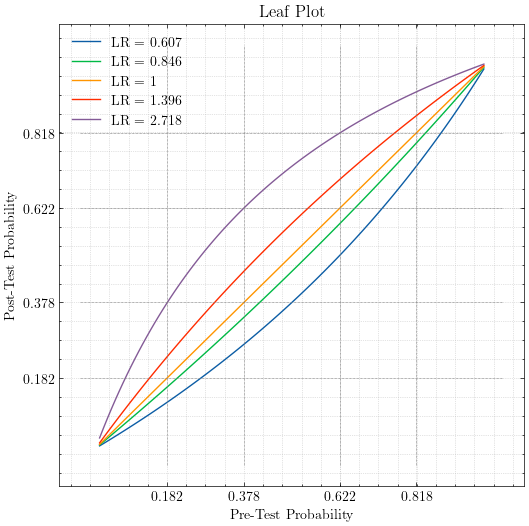

In [20]:
custom_gps = [0.182, 0.378, 0.622, 0.818] # corresponds to log-odds:  -1.5, -0.5, 0.5, 1.5
custom_lrs=[0.607, 0.846, 1, 1.396, 2.718]
leaf_plot(likelihood_ratios= custom_lrs, grid_positions=custom_gps)

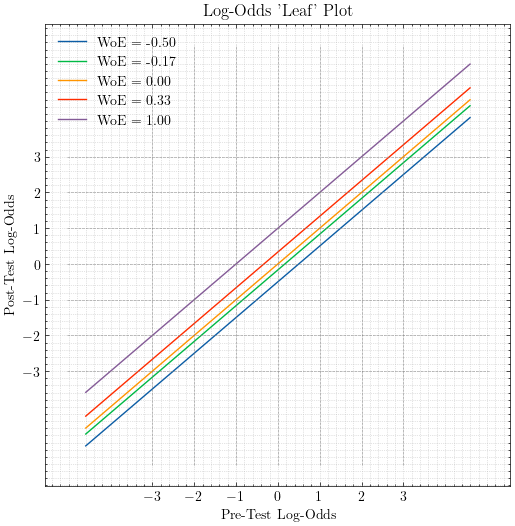

In [21]:
custom_woes= np.log([0.607, 0.846, 1, 1.396, 2.718])
log_odds_leaf_plot(weights_of_evidence=custom_woes)

The range of strengths of predictors that would be categorized as each type (major+, minor+, major-, minor-) are also clear to calculate in logarithmic space: 

- Major positive: WoE 2/3 or higher, LR+ of 1.948 or higher
- Minor positive: WoE of 2/3 to 1/6, LR+ of 1.181 to 1.948
- Not sufficiently informative to bother: 1/6 to -1/12, LR- of 0.920 to 1.181
- Minor negative: WoE of -1/12 to -1/3, LR- 0.717 to 0.920 
- Major negative: WoE -1/3 or lower, LR- below 0.717

## Part 4: Enter, Logistic Regression

Above, I mentioned that the log-odds scale is sometimes referred to as the logit scale - which may have reminded you of logistic regression. 

To briefly review, logistic regression is used when you want to take 1 or more predictors and estimate the probability of each of two outcomes (traditionally, 0 and 1). How it works is that linear predictors are combined, then the result is transformed by a sigmoid link function to constrain the output to probability space (0 to 1). Here is an excellent review of how this works: https://mlu-explain.github.io/logistic-regression/ 

Overall, the form is: 

$$
P(y = 1 | X) = \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

where

$$
z = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \dots + \hat{\beta}_k x_k
$$

where z is collectively referred to as the linear predictor, sigmoid is the link function, beta_0 is an intercept , and beta 1 through k are predictors. 

[ ] TODO: make an illustration of this

### What's this have to do with our Qualitative Bayes? 

Recall: 

- Post-test odds if + / Pretest Odds = +LR 
- Post-test odds if - / Pretest Odds = -LR

and 

- Post-test odds if + / Post-test odds if - = OR (odds ratio)

Therefore: 

- OR = Post-test odds if + / Post-test odds if - = [Post-test odds if + / Pretest Odds] / [Post-test odds if - / Pretest Odds] = +LR / -LR  

Also recall that the exponentiated coefficients from a logistic regression also give you the OR (odds ratio) associated with changing 1 unit in the predictor variable (say, from negative to positive). 

Therefore, we can define a logistic regression where the only predictor is the cumulative Weight of Evidence of all features and the intercept is the starting log odds. 

$$
P(y = 1 | X) = \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

where

$$
z = \text{Pretest\ Logodds} + \text{Cumulative\ WoE}
$$

In this case, we know the exponentiated linear predictor will equal the odds ratio (+LR / -LR), which exactly corresponds to the difference between going from 0 to 1. 

Thus, this allows us to easily calculated predicted probabilities using our Qualitative Bayes schema by: 

1. Estimate the pretest probability
2. Convert that to pretest odds, then pretest log-odds
3. Tally up all the major positive features (+1), minor positive features (+1/3), minor negative features (-1/3) and major negative features (-1/6) 
4. Then use this cumulative weight of evidence as a predictor in our logistic regression. 

This will be roughly accurate if the assumptions hold: 

1. Predictors are accurately classified or estimated to be major/minor features
2. Predictors are independent of one another
3. The spectrum of cases and non-cases in the studies where LRs were estimated from are similar to where it's being applied
4. We are only interested in discriminating "disease vs not-disease" (dichotomous) 


In [22]:
def logistic_regression_predict(pre_test_probability, weight_of_evidence):
    """
    Predict the probability using a logistic regression model with one predictor.
    
    Parameters:
        pre_test_probability (float): The intercept (baseline log-odds before including the predictor).
        weight_of_evidence (float): The predictor variable value.
        beta (float): The coefficient (weight) for the predictor = assumed to be 1.
    
    Returns:
        float: The predicted probability (between 0 and 1).
    """

    pre_test_log_odds = prob_to_logodds(pre_test_probability)
    
    # Compute the linear combination (log-odds)
    log_odds = pre_test_log_odds + weight_of_evidence
    
    # Convert log-odds to probability using the logistic (sigmoid) function
    probability = 1 / (1 + math.exp(-log_odds))
    
    return probability

In [23]:
#Static Example
num_major_positive = 2
num_major_negative = 4
num_minor_positive = 3 
num_minor_negative = 6
pre_test_prob = certainty_estimates['LIKELY']
#print(f"Probability for log-odds {prob_to_log_odds(certainty_estimates['UNLIKELY'])}: {certainty_estimates['UNLIKELY']}")

weight_of_evidence = num_major_positive - (num_major_negative/2) + (num_minor_positive/3) - (num_minor_negative/6)

predicted_probability = logistic_regression_predict(
    pre_test_prob,
    weight_of_evidence
)
print(f"Predicted probability: {predicted_probability:.3f}")


Predicted probability: 0.731


In [24]:
# Dynamic Example: 
from ipywidgets import interact
import ipywidgets as widgets

def predictor_wrapper(qual_pretest, major_positive, major_negative, minor_positive, minor_negative): 
    # Retrieve the pre-test probability based on the selected certainty level
    pre_test_prob = certainty_estimates[qual_pretest]
    print(f"Pretest probability: {pre_test_prob:.3f}")
    
    # Calculate the cumulative weight of evidence by combining input factors
    weight_of_evidence = (
        major_positive 
        - (major_negative / 2) 
        + (minor_positive / 3) 
        - (minor_negative / 6)
    )
    print(f"Cumulative Weight of Evidence: {weight_of_evidence:.3f}")
    
    # Use logistic regression to predict the post-test probability
    predicted_probability = logistic_regression_predict(pre_test_prob, weight_of_evidence)
    
    # Map the predicted probability to a certainty label
    certainty_label = get_certainty_label(predicted_probability)
    
    # Output the final results, including the predicted probability and corresponding label
    print(f"The predicted probability {predicted_probability:.3f} corresponds to: {certainty_label}")

# Create an interactive widget to input values and see the output in real-time
interact(
    predictor_wrapper, 
    qual_pretest=['HIGHLY_UNLIKELY', 'UNLIKELY', 'UNCERTAIN', 'LIKELY', 'HIGHLY_LIKELY'], 
    major_positive=widgets.IntSlider(value=0, min=0, max=6), 
    major_negative=widgets.IntSlider(value=0, min=0, max=6), 
    minor_positive=widgets.IntSlider(value=0, min=0, max=6), 
    minor_negative=widgets.IntSlider(value=0, min=0, max=6)
)

interactive(children=(Dropdown(description='qual_pretest', options=('HIGHLY_UNLIKELY', 'UNLIKELY', 'UNCERTAIN'…

<function __main__.predictor_wrapper(qual_pretest, major_positive, major_negative, minor_positive, minor_negative)>

### Visualizations 
#### TODO: make a visualization of the quantitative Bayes - perhaps with a dynamic leaf plot. 
##### Coeficient Plots
##### Dynamic leaf plot? 

## Part 5 Multi-Class Reasoning

### Problem conceptualization: dichotomous vs multi-class vs multi-label

[ ] todo: find multi-class vs binary image

#### Dichotomous Classification
Sensitivity, Specificity, Likelihood Ratios, Positive Predictive Values, etc. can all be calculated from a 2x2 'confusion matrix'. 


The confusion matrix summarizes positive and negative results for people who do and don't have the disease. 

As such, the LRs (and the others) only summarize evidence between two possibilities: the patient either has the disease of interest, or they do not. 

E.g. the patient either has pneumonia, or not pneumonia. 

#### Multi-class 

However, this is not exactly what we're doing in clinical reasoning. 

We're not interested in whether the patient has pneumonia or not pneumonia - we are interested in whether they have: 

1. Pneumonia
2. COPD
3. CHF
4. or, one of a few other causes of shortness of breath. 

Thus, if we make the assumption that one, and only one, of the diseases explain the patient's presentation, this is called a ***MULTI-CLASS*** classification problem.  This isn't as bad of an assumption as it might sound (as there is often one unifying diagnosis that explains the acute presentation, even when multiple diagnoses are present - see https://link.springer.com/article/10.1007/s11606-024-09120-y)

There is a generalization of logistic regression, called multinomial regression (not to be confused with multivariate regression) or softmax regression, that can be used to model this situation. Here is a website explaining more. https://chrisyeh96.github.io/2018/06/11/logistic-regression.html 

(some of this old discussion on twitter is relevant as well https://x.com/doc_blocke/status/1596920776820563968?s=12&t=5eJ6uoTQrbbYTlHIOnRYRg)

In [25]:
def softmax_regression_predict(pre_test_probabilities, weights_of_evidence):
    """
    Predict probabilities using a multinomial logistic regression model (softmax regression).
    
    Parameters:
        pre_test_probabilities (list of float): Pre-test probabilities (baseline probabilities before including predictors).
        weights_of_evidence (list of float): Linear predictors (log-odds contributions) for each class.
    
    Returns:
        list of float: Predicted probabilities for each class (summing to 1).
    
    Raises:
        ValueError: If the lengths of inputs don't match or if pre_test_probabilities contain invalid values.
    """
    
    if len(pre_test_probabilities) != len(weights_of_evidence):
        raise ValueError("The lengths of pre_test_probabilities and weights_of_evidence must be the same (equal to the number of diagnoses).")
    
    if not all(0 <= prob <= 1 for prob in pre_test_probabilities):
        raise ValueError("All pre_test_probabilities must be between 0 and 1.")
    
    combined = np.log(pre_test_probabilities) + np.array(weights_of_evidence)
    
    # Compute probabilities using the softmax function
    exp_combined = np.exp(combined - np.max(combined))  # Stability trick to avoid overflow
    probabilities = exp_combined / np.sum(exp_combined)
    
    return probabilities

There are a couple of implications of this model that we should investigate. 

First, since we assume that there is 1 (and only 1) correct diagnosis and that the correct diagnosis is in our set of possibilities, the total probability must sum to 1. 

Therefore if there are 3 diagnoses, they all can't be "UNCERTAIN" or higher (this would sum to over 1)

So, if all 3 were initially marked P = 0.5 (UNCERTAIN) and no net evidence in favor of any of them (weight of evence = 0, 0, and 0) we would get...

In [26]:
pre_test_probabilities = [0.5, 0.5, 0.5]
weights_of_evidence = [0, 0, 0]    # Weight of evidence (log-odds contributions)
dx_names = ['cardiac', 'gerd', 'pe']

post_testing_probabilities = softmax_regression_predict(pre_test_probabilities, weights_of_evidence)

print(post_testing_probabilities)
print([get_certainty_label(p) for p in post_testing_probabilities])

[0.33333333 0.33333333 0.33333333]
['UNLIKELY', 'UNLIKELY', 'UNLIKELY']


So, both pre-test (before evidence) and post-test (after evidence) probabilitis sum to 1. 

Now, let's change it a bit so that there's evidence in favor of GERD - and let's say the cumulative evidence is weight of evidence = 1 (aka +LR of 2.7)

In [27]:
dx_names = ['cardiac', 'gerd', 'pe']
print(dx_names)

pre_test_probabilities = [0.5, 0.5, 0.5]
print([get_certainty_label(p) for p in pre_test_probabilities])

weights_of_evidence = [0, 1, 0]    # Weight of evidence (log-odds contributions)

post_testing_probabilities = softmax_regression_predict(pre_test_probabilities, weights_of_evidence)

print(post_testing_probabilities)
print([get_certainty_label(p) for p in post_testing_probabilities])

['cardiac', 'gerd', 'pe']
['UNCERTAIN', 'UNCERTAIN', 'UNCERTAIN']
[0.21194156 0.57611688 0.21194156]
['UNLIKELY', 'UNCERTAIN', 'UNLIKELY']


One important intuition to build here: ***evidence for GERD is evidence against other explanations.***

This might seem odd, but it is true and it is the intuition behind the "PE most likely" contributor to the Wells Score (see: https://www.atsjournals.org/doi/10.1513/AnnalsATS.201908-590IP )

We can visualize these changes with stacked bar charts: 

In [28]:
def stacked_chart_pre_post(pre_test_probabilities, post_testing_probabilities, dx_names, weights_of_evidence, figsize=(6, 6)):
    """Visualize the changes in probabilities with dotted lines connecting the top and bottom of pre- and post-test bars."""
    # Check that input lengths match
    if not (len(pre_test_probabilities) == len(post_testing_probabilities) == len(dx_names) == len(weights_of_evidence)):
        raise ValueError("All input arrays must have the same length.")

    # Normalize the probabilities to ensure they sum to 1
    pre_test_probabilities = np.array(pre_test_probabilities) / np.sum(pre_test_probabilities)
    post_testing_probabilities = np.array(post_testing_probabilities) / np.sum(post_testing_probabilities)

    # Combine the data for stacked bar charts
    data = [pre_test_probabilities, post_testing_probabilities]

    # Labels for the x-axis
    x_labels = ["Before Info", "After Info"]

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Stacked bar chart
    x = np.arange(len(data))  # Positions for "Before" and "After"
    bottoms = np.zeros(len(data))  # To track stack heights
    width = 0.175  # Increased bar width for better visibility

    # Store top and bottom coordinates for dotted line drawing
    bar_tops = {i: [] for i in range(len(dx_names))}
    bar_bottoms = {i: [] for i in range(len(dx_names))}

    # Add bars and annotate probabilities
    for i, category in enumerate(dx_names):
        values = [data_point[i] for data_point in data]
        bars = ax.bar(x, values, width=width, bottom=bottoms, label=f"{category} (WoE: {weights_of_evidence[i]:.2f})")
        for j, (bar, value) in enumerate(zip(bars, values)):
            # Add text inside each bar
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{value:.2f}",
                ha="center",
                va="center",
                fontsize=10,
                color="white"
            )
            # Store the top and bottom of each bar
            bar_tops[i].append(bar.get_y() + bar.get_height())
            bar_bottoms[i].append(bar.get_y())

        bottoms += values

    # Add dotted lines connecting the top and bottom of each category
    for i in range(len(dx_names)):
        ax.plot(
            x,  # x-coordinates for "Before" and "After"
            bar_tops[i],  # y-coordinates for the tops of the bars
            linestyle="--", color="gray", alpha=0.5
        )
        ax.plot(
            x,  # x-coordinates for "Before" and "After"
            bar_bottoms[i],  # y-coordinates for the bottoms of the bars
            linestyle="--", color="gray", alpha=0.5
        )

    # Add labels, title, and legend
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel("Probability")
    ax.set_title("Before-Data vs After-Data Probabilities")

    # Move the legend below the chart
    ax.legend(title="Diagnoses", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

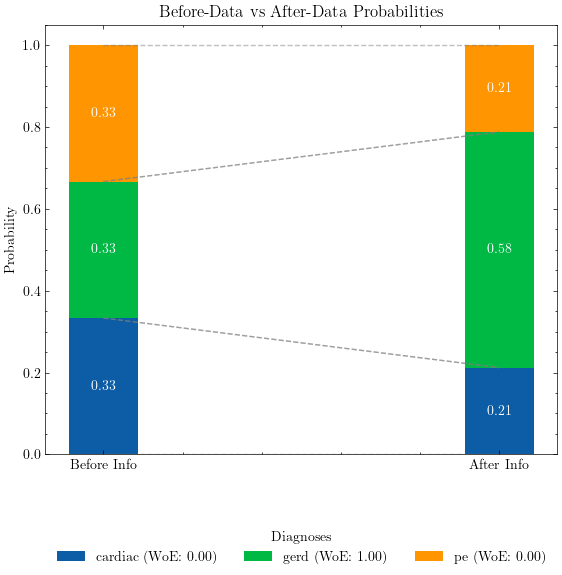

In [29]:
stacked_chart_pre_post(pre_test_probabilities, post_testing_probabilities, dx_names, weights_of_evidence)

Relatedly, if there is evidence against one of the items on the differential diagnosis, that is necessarily evidence in favor of the remaining options

['cardiac', 'gerd', 'pe', 'pna']
['HIGHLY_UNLIKELY', 'HIGHLY_UNLIKELY', 'UNCERTAIN', 'UNLIKELY']
[0.16110125 0.16110125 0.35559502 0.32220249]
['HIGHLY_UNLIKELY', 'HIGHLY_UNLIKELY', 'UNLIKELY', 'UNLIKELY']


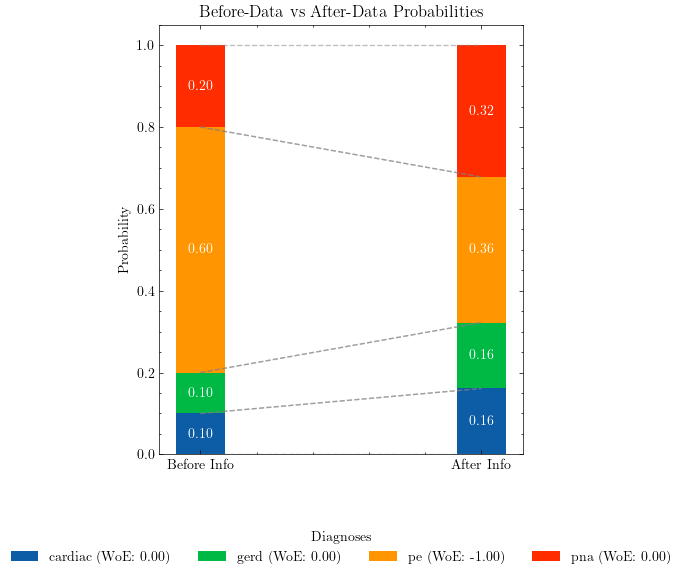

In [30]:
dx_names = ['cardiac', 'gerd', 'pe', 'pna']
print(dx_names)

pre_test_probabilities = [0.1, 0.1, 0.6, 0.2]
print([get_certainty_label(p) for p in pre_test_probabilities])

weights_of_evidence = [0, 0, -1, 0] 
post_testing_probabilities = softmax_regression_predict(pre_test_probabilities, weights_of_evidence)

print(post_testing_probabilities)
print([get_certainty_label(p) for p in post_testing_probabilities])

stacked_chart_pre_post(pre_test_probabilities, post_testing_probabilities, dx_names, weights_of_evidence)


And, things can get complicated if you have lots of supporting evidence that supports lots of diagnoses

['cardiac', 'gerd', 'esoph dysph', 'ra', 'crest']
['UNLIKELY', 'UNLIKELY', 'UNLIKELY', 'HIGHLY_UNLIKELY', 'HIGHLY_UNLIKELY']
[0.39800742 0.01201878 0.08880746 0.0146903  0.48647604]
['UNCERTAIN', 'HIGHLY_UNLIKELY', 'HIGHLY_UNLIKELY', 'HIGHLY_UNLIKELY', 'UNCERTAIN']


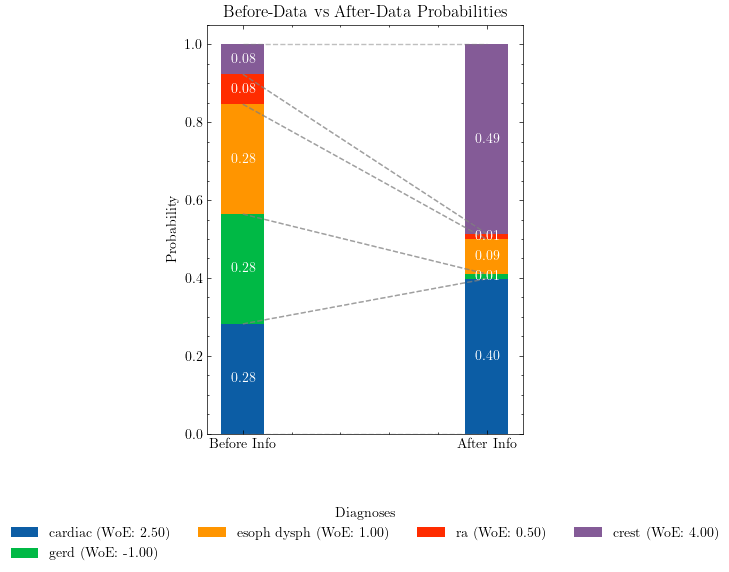

In [31]:
dx_names = ['cardiac', 'gerd', 'esoph dysph', 'ra', 'crest']
print(dx_names)

pre_test_probabilities = [odds_to_probability(0.5), odds_to_probability(0.5), odds_to_probability(0.5), odds_to_probability(0.1), odds_to_probability(0.1)]
print([get_certainty_label(p) for p in pre_test_probabilities])

weights_of_evidence = [2.5, -1, 1, 0.5, 4] 
post_testing_probabilities = softmax_regression_predict(pre_test_probabilities, weights_of_evidence)

print(post_testing_probabilities)
print([get_certainty_label(p) for p in post_testing_probabilities])

stacked_chart_pre_post(pre_test_probabilities, post_testing_probabilities, dx_names, weights_of_evidence)

And here's a dynamic widget where you can play with the number of diagnoses and the number of major and minor features and see what the resulting predicted likelihoods will be. 

In [32]:
from ipywidgets import interact, widgets, VBox, HBox, Layout, Output

# Generalized wrapper function for n diagnoses
def generalized_predictor_wrapper(diagnoses):
    """
    Wrapper function to compute post-test probabilities for all diagnoses using softmax regression.

    Parameters:
        diagnoses (list): List of dictionaries, each containing the details of a diagnosis.
    
    Returns:
        dict: Dictionary containing names, normalized pre-test probabilities, weights of evidence, and post-test probabilities.
    """
    # Gather pre-test probabilities and cumulative weights of evidence
    pre_test_probs = []
    weights_of_evidence = []
    names = []

    for diagnosis in diagnoses:
        name = diagnosis['name']
        pre_test_prob = certainty_estimates[diagnosis['pretest']]
        major_positive = diagnosis['major_positive']
        major_negative = diagnosis['major_negative']
        minor_positive = diagnosis['minor_positive']
        minor_negative = diagnosis['minor_negative']

        # Calculate the cumulative weight of evidence for this diagnosis
        weight_of_evidence = (
            major_positive 
            - (major_negative / 2) 
            + (minor_positive / 3) 
            - (minor_negative / 6)
        )

        # Append data
        pre_test_probs.append(pre_test_prob)
        weights_of_evidence.append(weight_of_evidence)
        names.append(name)

    # Normalize pre-test probabilities
    pre_test_sum = sum(pre_test_probs)
    norm_pre_test_probs = [p / pre_test_sum for p in pre_test_probs]

    # Use softmax regression to calculate post-test probabilities
    predicted_probs = softmax_regression_predict(pre_test_probs, weights_of_evidence)

    # Create result dictionary
    results = {
        'names': names,
        'pre_test_probs': pre_test_probs,
        'norm_pre_test_probs': norm_pre_test_probs,
        'weights_of_evidence': weights_of_evidence,
        'predicted_probs': predicted_probs
    }

    # Display the results
    print(f"{'Diagnosis':<15}{'Pre-Test Prob':<15}{'Norm Pre-Test Prob':<20}{'WoE':<15}{'Post-Test Prob':<15}")
    print("-" * 80)
    for i, name in enumerate(names):
        print(f"{name:<15}{pre_test_probs[i]:<15.3f}{norm_pre_test_probs[i]:<20.3f}{weights_of_evidence[i]:<15.3f}{predicted_probs[i]:<15.3f}")

    return results


# Dynamic widget for n diagnoses
def create_diagnosis_widget():
    """
    Creates an interactive widget for entering diagnosis details and calculating post-test probabilities
    using softmax regression, displaying the stacked chart dynamically.
    
    Returns:
        VBox: A vertical box containing the interactive widget.
    """
    # Define dynamic widgets for n diagnoses
    diagnosis_count = widgets.IntSlider(value=1, min=1, max=10, step=1, description="Diagnoses")
    container = VBox()
    chart_output = Output()  # Output widget to display the chart

    # Function to update the widgets based on the number of diagnoses
    def update_widgets(change):
        if change['name'] == 'value':  # Ensure the change is triggered by the slider
            container.children = []  # Clear the container before updating
            for i in range(change['new']):  # Iterate over the new diagnosis count
                name_widget = widgets.Text(value=f"Diagnosis {i+1}", description="Name:")
                pretest_widget = widgets.Dropdown(
                    options=['HIGHLY_UNLIKELY', 'UNLIKELY', 'UNCERTAIN', 'LIKELY', 'HIGHLY_LIKELY'],
                    value='UNCERTAIN',
                    description="Pre-Test:"
                )
                major_pos_widget = widgets.IntSlider(value=0, min=0, max=10, step=1, description="Major+")
                major_neg_widget = widgets.IntSlider(value=0, min=0, max=10, step=1, description="Major-")
                minor_pos_widget = widgets.IntSlider(value=0, min=0, max=10, step=1, description="Minor+")
                minor_neg_widget = widgets.IntSlider(value=0, min=0, max=10, step=1, description="Minor-")

                # Combine all widgets for one diagnosis
                diagnosis_box = VBox([name_widget, pretest_widget, major_pos_widget, major_neg_widget, minor_pos_widget, minor_neg_widget])
                container.children += (diagnosis_box,)  # Add to the container

    # Observe changes in the slider and update widgets accordingly
    diagnosis_count.observe(update_widgets, names='value')

    # Trigger an initial update
    update_widgets({'name': 'value', 'new': diagnosis_count.value})

    # Function to gather inputs from the widgets
    def gather_inputs():
        diagnoses = []
        for diagnosis_box in container.children:
            name = diagnosis_box.children[0].value
            pretest = diagnosis_box.children[1].value
            major_positive = diagnosis_box.children[2].value
            major_negative = diagnosis_box.children[3].value
            minor_positive = diagnosis_box.children[4].value
            minor_negative = diagnosis_box.children[5].value
            diagnoses.append({
                'name': name,
                'pretest': pretest,
                'major_positive': major_positive,
                'major_negative': major_negative,
                'minor_positive': minor_positive,
                'minor_negative': minor_negative
            })

        # Clear chart output before displaying a new one
        chart_output.clear_output()

        # Compute results and display chart
        with chart_output:
            results = generalized_predictor_wrapper(diagnoses)
            stacked_chart_pre_post(
                results['pre_test_probs'],
                results['predicted_probs'],
                results['names'],
                results['weights_of_evidence']
            )

    # Add a button to trigger the calculation
    calculate_button = widgets.Button(description="Calculate")
    calculate_button.on_click(lambda x: gather_inputs())

    # Combine the slider, container, and calculate button
    return HBox([VBox([diagnosis_count, container, calculate_button]), chart_output])

In [33]:
diagnosis_widget = create_diagnosis_widget()
display(diagnosis_widget)

In [ ]:
# TODO: make a version of the above applet that just takes cumulative Log(LRs) of evidence in favor of each diagnoses and calculates the updated chart
# This might make an interesting stand-alone applet or shiny-ish app

TODO list: 

[ ] discuss the multi-label situation - actually doable with non-normalized logistic regressions.

[ ] discuss difference from Entropy approach - different loss functions *** can't recall the details here, search for the correct citations.

